In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [2]:
connect_db = sqlite3.connect('../data/checking-logs.sqlite.sqlite')
query = '''
        select uid, count(1) as count_page from pageviews where uid like 'user_%' group by uid
        '''
df_view_pages = pd.io.sql.read_sql(query, connect_db)
df_view_pages

,uid,count_page
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [4]:
connect_db = sqlite3.connect('../data/checking-logs.sqlite.sqlite')
query = '''
        select uid, count(1) as count_chek from checker where uid in (select uid from pageviews where uid like 'user_%') and labname <> 'project1' group by uid
        '''
df_checker = pd.io.sql.read_sql(query, connect_db)
df_checker

,uid,count_chek
0,user_1,62
1,user_10,20
2,user_14,61
3,user_17,51
4,user_18,5
5,user_19,118
6,user_21,65
7,user_25,79
8,user_28,60
9,user_3,18


In [5]:
query = '''
select checker.uid, checker.labname,  checker.timestamp as first_commit_ts, pageviews.datetime as first_view_ts
from checker
left join pageviews ON checker.uid = pageviews.uid
where status='ready' and numTrials=1 and labname IN ('laba04', 'laba04s', 'laba05','laba06', 'laba06s')
and checker.uid like 'user_%' and (pageviews.datetime = (select MIN(pageviews.datetime) from pageviews where pageviews.uid=checker.uid) or pageviews.datetime IS NULL)
'''
ds = pd.io.sql.read_sql(query, connect_db,parse_dates=['first_commit_ts', 'first_view_ts'])
ds = ds[ds.first_view_ts.notnull()]
ds['diff'] = (ds.first_view_ts - ds.first_commit_ts).dt.total_seconds().div(3600)
rest_df = ds.groupby(ds.uid).mean()['diff'].reset_index()
rest_df = rest_df.sort_values('uid')

In [7]:
rest_df = pd.concat([rest_df,df_view_pages,df_checker], axis=1)
rest_df.columns = ['uid', 'diff', 'uid1', 'count_page','uid2', 'count_chek']
rest_df.drop(rest_df.columns[[2, 4]], axis=1, inplace=True)
# rest_df.drop(n)
rest_df.dropna(subset=['uid'], inplace=True)
rest_df

,uid,diff,count_page,count_chek
0,user_1,-239.380182,28,62.0
1,user_10,-430.826806,89,20.0
2,user_14,-101.533075,143,61.0
3,user_17,-445.243366,47,51.0
4,user_18,-50.807026,3,5.0
5,user_19,-402.048859,16,118.0
6,user_21,-211.211785,10,65.0
7,user_25,102.990101,179,79.0
8,user_28,117.524583,149,60.0
9,user_3,78.234742,317,18.0


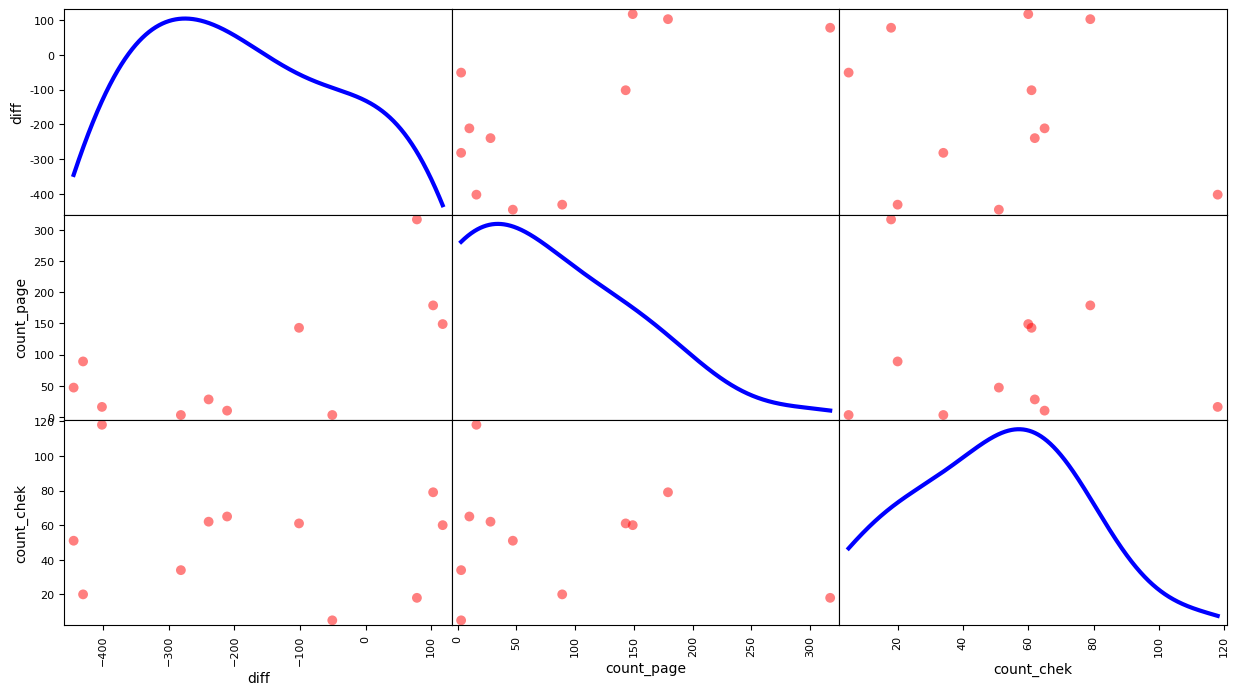

In [11]:
ax = scatter_matrix(rest_df, figsize=(15, 8), diagonal='kde', density_kwds=dict(color='blue', linewidth=3), s=200, color='red')

***1 - NO***
***2 - NO***
***3 - YES***
***4 - YES***

In [13]:
connect_db.close()